# Setup

In [2]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates
from tqdm import tqdm

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D
import datetime as dt

# make sure the figures plot inline rather than at the end
%matplotlib inline

# Parameters

In [4]:
bounds = [35,120,-20,30] # for all binning

# these are for grouping into IOD peak season and non peak season
IODseason_begin = 8
IODseason_end = 12

# these are for grouping into the IOD years since the effects are 
# not confined to a single year. You chose this to have an even 
# number of months around the IOD peak..but now you left it in
# line with the SLA plots that start in 06 and end in 05
IODyear_begin = '-06-01' # month-day of IOD year
IODyear_end = '-05-31' # month-day of year AFTER IOD year

# # define months to start and end on when sampling
# begin = '-05-01' #iod year
# end = '-04-30'  # post iod year

var_type = '10_200' #'TCD_200', '10_50', '10_200', 'total'

# Functions

In [5]:
def add_land(ax,bounds= [35,120,-20,30]):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

def gaus_filter_nan(img,sigma = 1):
    # import required packages
    from astropy.convolution import convolve
    from astropy.convolution import Gaussian2DKernel
    
    # create a kernal with std = 1
    kernel = Gaussian2DKernel(x_stddev=1)
    
    #convolve that with the 2d matrix
    img_conv = convolve(img, kernel)

    # set original nan points back to nans
    img_conv[np.isnan(img)] = np.nan

    return img_conv

# mask coastlines ---------------------------------------------------------------------#
def mask_coast(c_lon,c_lat,bounds):
    data=xr.open_dataset('/tigress/GEOCLIM/LRGROUP/shared_data/pco2_flux_coastal_Roobaert/mask_ocean.nc')
    mask_coast=np.array(data.mask_coastal2).astype(int).T
    lat=np.array(data.latitude)
    lon=np.array(data.longitude)

    mask_lon=np.logical_and(lon>bounds[0],lon<bounds[1])
    mask_lat=np.logical_and(lat>bounds[2],lat<bounds[3])

    lon=lon[mask_lon]
    lat=lat[mask_lat]

    mask_coast=mask_coast[mask_lat]
    mask_coast=mask_coast[:,mask_lon]

    lonlon,latlat=np.meshgrid(lon,lat)

    # what are these for? I should probably fix it
    lon_dot=np.array([70,70])
    lat_dot=np.array([10,19.5])

    mask=[]
    for lo,la in zip(c_lon,c_lat):
        if len(lon[lon<=lo])>0 and len(lat[lat>=la])>0 and len(lon[lon>=lo])>0 and len(lat[lat<=la])>0:
            lon_lim=[lon[lon<=lo][-1],lon[lon>=lo][0]]
            lat_lim=[lat[lat<=la][-1],lat[lat>=la][0]]
            mask_lon=np.logical_or(lon==lon_lim[0],lon==lon_lim[1])
            mask_lat=np.logical_or(lat==lat_lim[0],lat==lat_lim[1])
            mask_tmp=mask_coast[mask_lat]
            mask_tmp=mask_tmp[:,mask_lon]
            mask.append(np.mean(mask_tmp)>0)
        else:
            mask.append(False)
    mask=np.array(mask)
    return mask


# Read Data

In [6]:
# get data from tigress
ds_CD = xr.open_dataset('../data/CD/cd_awg.nc')
# ds_CD

# Find IOD / Not Seasons

In [7]:
month = ds_CD.coast_time.dt.month
month = np.array(month)
IODseason_coast = np.full(month.shape,1)

# ------------------------------------------------------------#
# Based on IOD peak
# ------------------------------------------------------------#
if IODseason_end < IODseason_begin:
    IODseason_coast = np.where((month >= IODseason_begin) | (month <= IODseason_end),IODseason_coast,0)
else:
    IODseason_coast = np.where((month >= IODseason_begin) & (month <= IODseason_end),IODseason_coast,0)

# add to dataset
ds_CD['IODseason_coast'] = xr.DataArray(IODseason_coast,dims = ['coast_time'],coords =[ds_CD.coast_time])

# Get IOD Phases

In [8]:
# load DMI data
ds_DMI= xr.open_dataset('../data/DMI/dmi_processed.nc')
ds_DMI

posIODyears = list(np.array(ds_DMI.pos_IOD_years))
negIODyears = list(np.array(ds_DMI.neg_IOD_years))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) 

# Define Coastal AS and BoB bounds For Anomaly PDFs

NameError: name 'doxy_BoB' is not defined

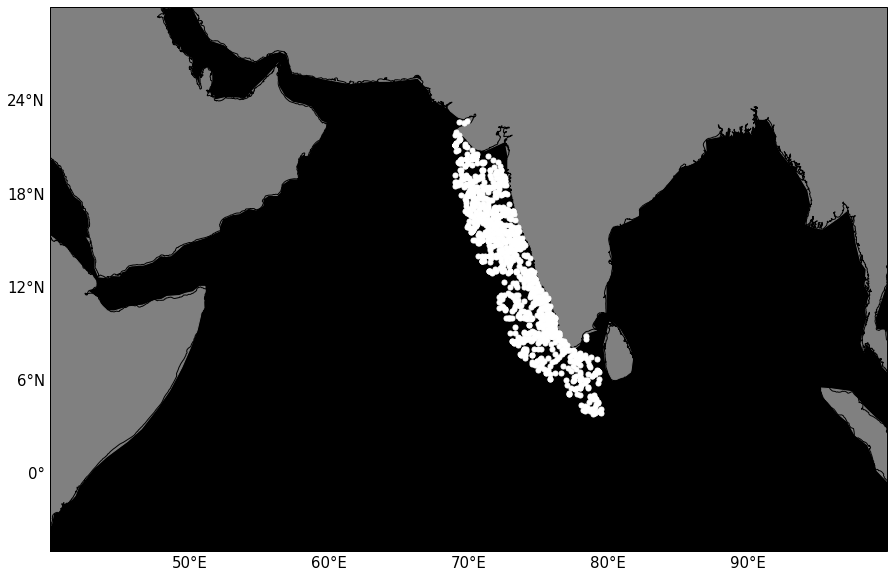

In [9]:
var_type = '10_200'

# Arabian Sea
ASind = (ds_CD.lat_coast > 3) & (ds_CD.lat_coast <25.25) & (ds_CD.lon_coast < 79.5) & (ds_CD.lon_coast >69)
# ASind = (ds_CD.lat_coast > 6) & (ds_CD.lat_coast <21) & (ds_CD.lon_coast < 78) & (ds_CD.lon_coast >69)
# ASind = (ds_CD.lat_coast > 8) & (ds_CD.lat_coast <23) & (ds_CD.lon_coast < 78) & (ds_CD.lon_coast >68)


if var_type == '10_200':
    temp_AS = ds_CD.temp_10_200_ave_coast[ASind]
    doxy_AS = ds_CD.doxy_10_200_ave_coast[ASind]
    temp_anom_AS = ds_CD.temp_anom_10_200_ave_coast[ASind]
    doxy_anom_AS = ds_CD.doxy_anom_10_200_ave_coast[ASind]
elif var_type == 'TCP_200':
    temp_AS = ds_CD.temp_TCP_200_ave_coast[ASind]
    doxy_AS = ds_CD.doxy_TCP_200_ave_coast[ASind]
    temp_anom_AS = ds_CD.temp_anom_TCP_200_ave_coast[ASind]
    doxy_anom_AS = ds_CD.doxy_anom_TCP_200_ave_coast[ASind]
elif var_type == '10_50':
    temp_AS = ds_CD.temp_10_50_ave_coast[ASind]
    doxy_AS = ds_CD.doxy_10_50_ave_coast[ASind]
    temp_anom_AS = ds_CD.temp_anom_10_50_ave_coast[ASind]
    doxy_anom_AS = ds_CD.doxy_anom_10_50_ave_coast[ASind]

lat_AS = ds_CD.lat_coast[ASind]
lon_AS = ds_CD.lon_coast[ASind]
IODseas_AS = ds_CD.IODseason_coast[ASind]
time_AS = ds_CD.coast_time[ASind]
seas_AS = time_AS.dt.season



BoBind = (ds_CD.lat_coast >= 0) & (ds_CD.lat_coast <26) & (ds_CD.lon_coast < 99) & (ds_CD.lon_coast > 80)
# BoBind = (ds_CD.lat_coast >= 10) & (ds_CD.lat_coast <26) & (ds_CD.lon_coast < 90) & (ds_CD.lon_coast > 80)
# BoBind = (ds_CD.lat_coast > 2) & (ds_CD.lat_coast <20) & (ds_CD.lon_coast < 101) & (ds_CD.lon_coast >90)


if var_type == '10_200':
    temp_BoB = ds_CD.temp_10_200_ave_coast[BoBind]
    doxy_BoB = ds_CD.doxy_10_200_ave_coast[BoBind]
    temp_anom_BoB = ds_CD.temp_anom_10_200_ave_coast[BoBind]
    doxy_anom_BoB = ds_CD.doxy_anom_10_200_ave_coast[BoBind]
elif var_type == 'TCP_200':
    temp_BoB = ds_CD.temp_TCP_200_ave_coast[BoBind]
    doxy_BoB = ds_CD.doxy_TCP_200_ave_coast[BoBind]
    temp_anom_BoB = ds_CD.temp_anom_TCP_200_ave_coast[BoBind]
    doxy_anom_BoB = ds_CD.doxy_anom_TCP_200_ave_coast[BoBind]

lat_BoB = ds_CD.lat_coast[BoBind]
lon_BoB = ds_CD.lon_coast[BoBind]
IODseas_BoB = ds_CD.IODseason_coast[BoBind]
time_BoB = ds_CD.coast_time[BoBind]
seas_BoB = time_BoB.dt.season

def add_land(ax,bounds):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='10m',zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

bounds = [40,100,-5,30]
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
p =plt.scatter(lon_AS[~np.isnan(doxy_AS)],lat_AS[~np.isnan(doxy_AS)],
            s = 100,c='white',marker = '.')

p =plt.scatter(lon_BoB[~np.isnan(doxy_BoB)],lat_BoB[~np.isnan(doxy_BoB)],
            s = 100,c='pink',marker = '.')

# Anomaly PDFs

In [51]:
doxy_IODData = np.zeros([2,2,3], dtype=np.ndarray)
temp_IODData = np.zeros([2,2,3], dtype=np.ndarray)
doxy_anom_IODData = np.zeros([2,2,3], dtype=np.ndarray)
temp_anom_IODData = np.zeros([2,2,3], dtype=np.ndarray)
lat_IODData = np.zeros([2,2,3], dtype=np.ndarray)
lon_IODData = np.zeros([2,2,3], dtype=np.ndarray)
time_IODData = np.zeros([2,2,3], dtype=np.ndarray)

for bb in range(2):
    if bb == 0:
        temp = temp_BoB
        doxy = doxy_BoB
        temp_anom = temp_anom_BoB
        doxy_anom = doxy_anom_BoB
        lat = lat_BoB
        lon = lon_BoB
        IODseason = IODseas_BoB
        season = seas_BoB
        t = time_BoB
    else:
        temp = temp_AS
        doxy = doxy_AS
        temp_anom = temp_anom_AS
        doxy_anom = doxy_anom_AS
        lat = lat_AS
        lon = lon_AS
        IODseason = IODseas_AS
        season = seas_AS
        t = time_AS

    IODyears = [posIODyears,negIODyears,neuIODyears]
    
    for pp,phase in enumerate(IODyears):
        
        doxy_data = []
        temp_data = []
        doxy_anom_data = []
        temp_anom_data = []
        lat_data = []
        lon_data = []
        time_data = []
        IODseason_data = []
        season_data = []

        for ii,year in enumerate(phase):
            start_time = str(year) + IODyear_begin
            end_time = str(year+1) + IODyear_end
            time_slice = slice(start_time, end_time)
            doxy_data.extend(np.array(doxy.sel(coast_time=time_slice)))
            temp_data.extend(np.array(temp.sel(coast_time=time_slice)))
            doxy_anom_data.extend(np.array(doxy_anom.sel(coast_time=time_slice)))
            temp_anom_data.extend(np.array(temp_anom.sel(coast_time=time_slice)))
            lat_data.extend(np.array(lat.sel(coast_time=time_slice)))
            lon_data.extend(np.array(lon.sel(coast_time=time_slice)))
            time_data.extend(np.array(t.sel(coast_time=time_slice)))
            IODseason_data.extend(np.array(IODseason.sel(coast_time=time_slice)))
            season_data.extend(np.array(season.sel(coast_time=time_slice)))
            
        # next group by seasons
        # create a pandas dataframe
        df = pd.DataFrame(dict(
                doxy = np.array(doxy_data),
                temp = np.array(temp_data),
                doxy_anom = np.array(doxy_anom_data),
                temp_anom = np.array(temp_anom_data),
                lat= np.array(lat_data),
                lon= np.array(lon_data),
                time = np.array(time_data),
                IODseason = np.array(IODseason_data),
                season = np.array(season_data)
            ))
            
        IODseas_grouped = df.groupby(['IODseason'])
        
        for ss,IODseas_group in IODseas_grouped:
            doxy_IODData[bb,ss,pp] = np.array(IODseas_group.doxy)
            temp_IODData[bb,ss,pp] = np.array(IODseas_group.temp)
            doxy_anom_IODData[bb,ss,pp] = np.array(IODseas_group.doxy_anom)
            temp_anom_IODData[bb,ss,pp] = np.array(IODseas_group.temp_anom)
            lat_IODData[bb,ss,pp] = np.array(IODseas_group.lat)
            lon_IODData[bb,ss,pp] = np.array(IODseas_group.lon)
            time_IODData[bb,ss,pp] = np.array(IODseas_group.time)
            

# Total

238
103
103
117
59
59


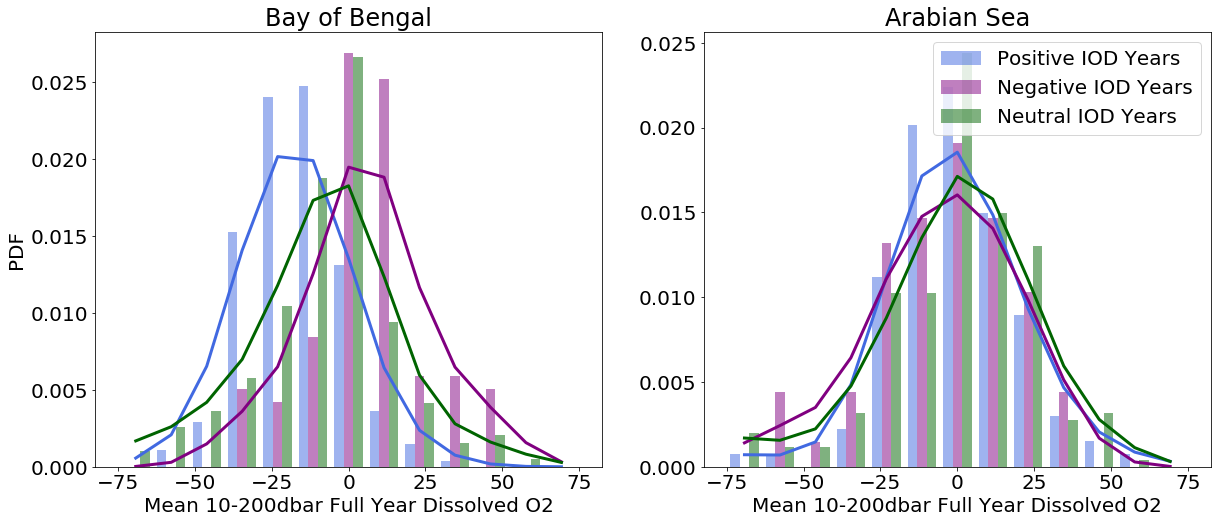

In [52]:
# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#
var = doxy_anom_IODData
binedges = np.linspace(-75,75,14)

cnt = 1
seas_title = ['Bay of Bengal', 'Arabian Sea']
fig = plt.figure(figsize=(20, 8))
plt.rcParams.update({'font.size': 20})
for loc in range(2):
    # Make a separate list for each airline
#     x1 = list(np.concatenate((var[loc,0,0],var[loc,1,0])))
#     x2 = list(np.concatenate((var[loc,0,1],var[loc,1,1])))
#     x3 = list(np.concatenate((var[loc,0,2],var[loc,1,2])))

    x1 = list(var[loc,1,0])
    x2 = list(var[loc,1,1])
    x3 = list(var[loc,1,2])
    
    tmpx1 = np.array(x1)
    print(np.sum(~np.isnan(tmpx1)))
    
    tmpx2 = np.array(x2)
    print(np.sum(~np.isnan(tmpx2)))
    
    tmpx2 = np.array(x2)
    print(np.sum(~np.isnan(tmpx2)))

    # Assign colors for each airline and the names
    colors = ['royalblue','purple','darkgreen']
    names = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']

    # Make the histogram using a list of lists
    # Normalize the flights and assign colors and names
    ax = fig.add_subplot(1,2,cnt)
    n, bins, patches = plt.hist([x1,x2,x3],bins = binedges,
             density = True,alpha = 0.5,
             color = colors, label=names)
#     for ii,x in enumerate([x1,x2,x3]):
#         mu = np.nanmean(x)
#         sigma = np.nanstd(x)
#         y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
#          np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
#         plt.plot(bins, y, '-',c = colors[ii],linewidth = 3)
    for ii,x in enumerate([x1,x2,x3]):
        n, bins, patches = plt.hist(x,bins = binedges,
             density = True,
             alpha = 0,
             color = 'w')
        bins=(np.array(bins)[:-1]+np.array(bins)[1:])/2
        plt.plot(bins, gaussian_filter(n,1), '-',c = colors[ii],linewidth = 3)



    if var_type == 'TCP_200':
        plt.xlabel('Mean TCP-200dbar IOD Season Dissolved O2')
    elif var_type == '10_200':
        plt.xlabel('Mean 10-200dbar Full Year Dissolved O2')
    elif var_type == '10_50':
        plt.xlabel('Mean 10-50dbar Full Year Dissolved O2')
    elif var_type == 'total':
        plt.xlabel('Mean Water Column Full Year Dissolved O2')
        
    if (cnt == 1) | (cnt ==3)| (cnt ==5):
        plt.ylabel('PDF')
    if (cnt == 1) | (cnt ==2):
        plt.title(seas_title[loc])
    if cnt == 2:
        plt.legend()
    cnt = cnt + 1

296
150
150
203
105
105


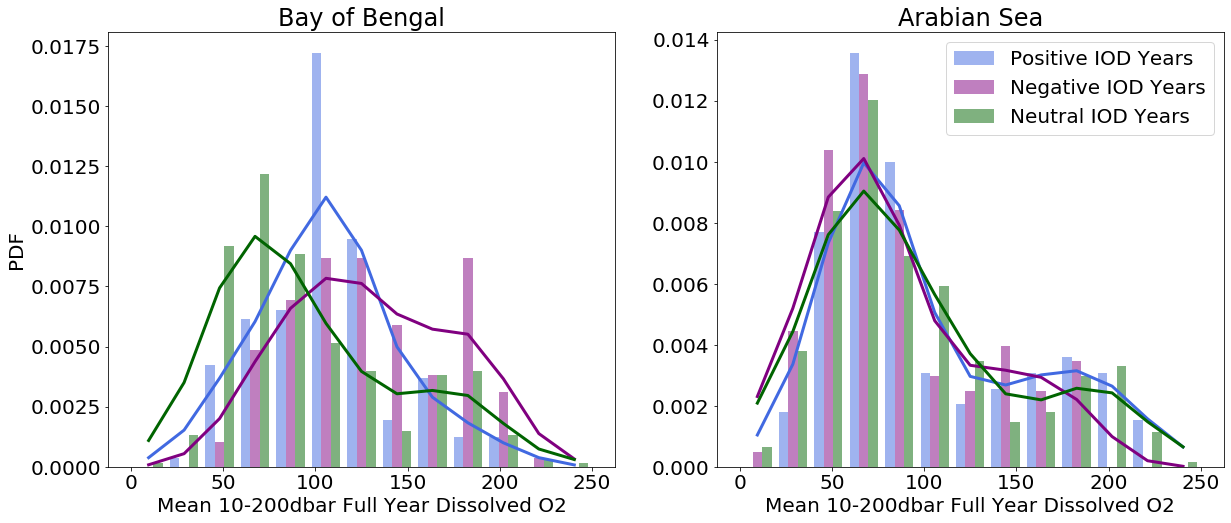

In [54]:
# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#
var = doxy_IODData
binedges = np.linspace(0,250,14)

cnt = 1
seas_title = ['Bay of Bengal', 'Arabian Sea']
fig = plt.figure(figsize=(20, 8))
plt.rcParams.update({'font.size': 20})
for loc in range(2):
    # Make a separate list for each airline
    x1 = list(np.concatenate((var[loc,0,0],var[loc,1,0])))
    x2 = list(np.concatenate((var[loc,0,1],var[loc,1,1])))
    x3 = list(np.concatenate((var[loc,0,2],var[loc,1,2])))

    x1 = list(var[loc,1,0])
    x2 = list(var[loc,1,1])
    x3 = list(var[loc,1,2])
    
    tmpx1 = np.array(x1)
    print(np.sum(~np.isnan(tmpx1)))
    
    tmpx2 = np.array(x2)
    print(np.sum(~np.isnan(tmpx2)))
    
    tmpx2 = np.array(x2)
    print(np.sum(~np.isnan(tmpx2)))

    # Assign colors for each airline and the names
    colors = ['royalblue','purple','darkgreen']
    names = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']

    # Make the histogram using a list of lists
    # Normalize the flights and assign colors and names
    ax = fig.add_subplot(1,2,cnt)
    n, bins, patches = plt.hist([x1,x2,x3],bins = binedges,
             density = True,alpha = 0.5,
             color = colors, label=names)
#     for ii,x in enumerate([x1,x2,x3]):
#         mu = np.nanmean(x)
#         sigma = np.nanstd(x)
#         y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
#          np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
#         plt.plot(bins, y, '-',c = colors[ii],linewidth = 3)
    for ii,x in enumerate([x1,x2,x3]):
        n, bins, patches = plt.hist(x,bins = binedges,
             density = True,
             alpha = 0,
             color = 'w')
        bins=(np.array(bins)[:-1]+np.array(bins)[1:])/2
        plt.plot(bins, gaussian_filter(n,1), '-',c = colors[ii],linewidth = 3)



    if var_type == 'TCP_200':
        plt.xlabel('Mean TCP-200dbar IOD Season Dissolved O2')
    elif var_type == '10_200':
        plt.xlabel('Mean 10-200dbar Full Year Dissolved O2')
    elif var_type == '10_50':
        plt.xlabel('Mean 10-50dbar Full Year Dissolved O2')
    elif var_type == 'total':
        plt.xlabel('Mean Water Column Full Year Dissolved O2')
        
    if (cnt == 1) | (cnt ==3)| (cnt ==5):
        plt.ylabel('PDF')
    if (cnt == 1) | (cnt ==2):
        plt.title(seas_title[loc])
    if cnt == 2:
        plt.legend()
    cnt = cnt + 1

# Anomaly PDFs

## Temp

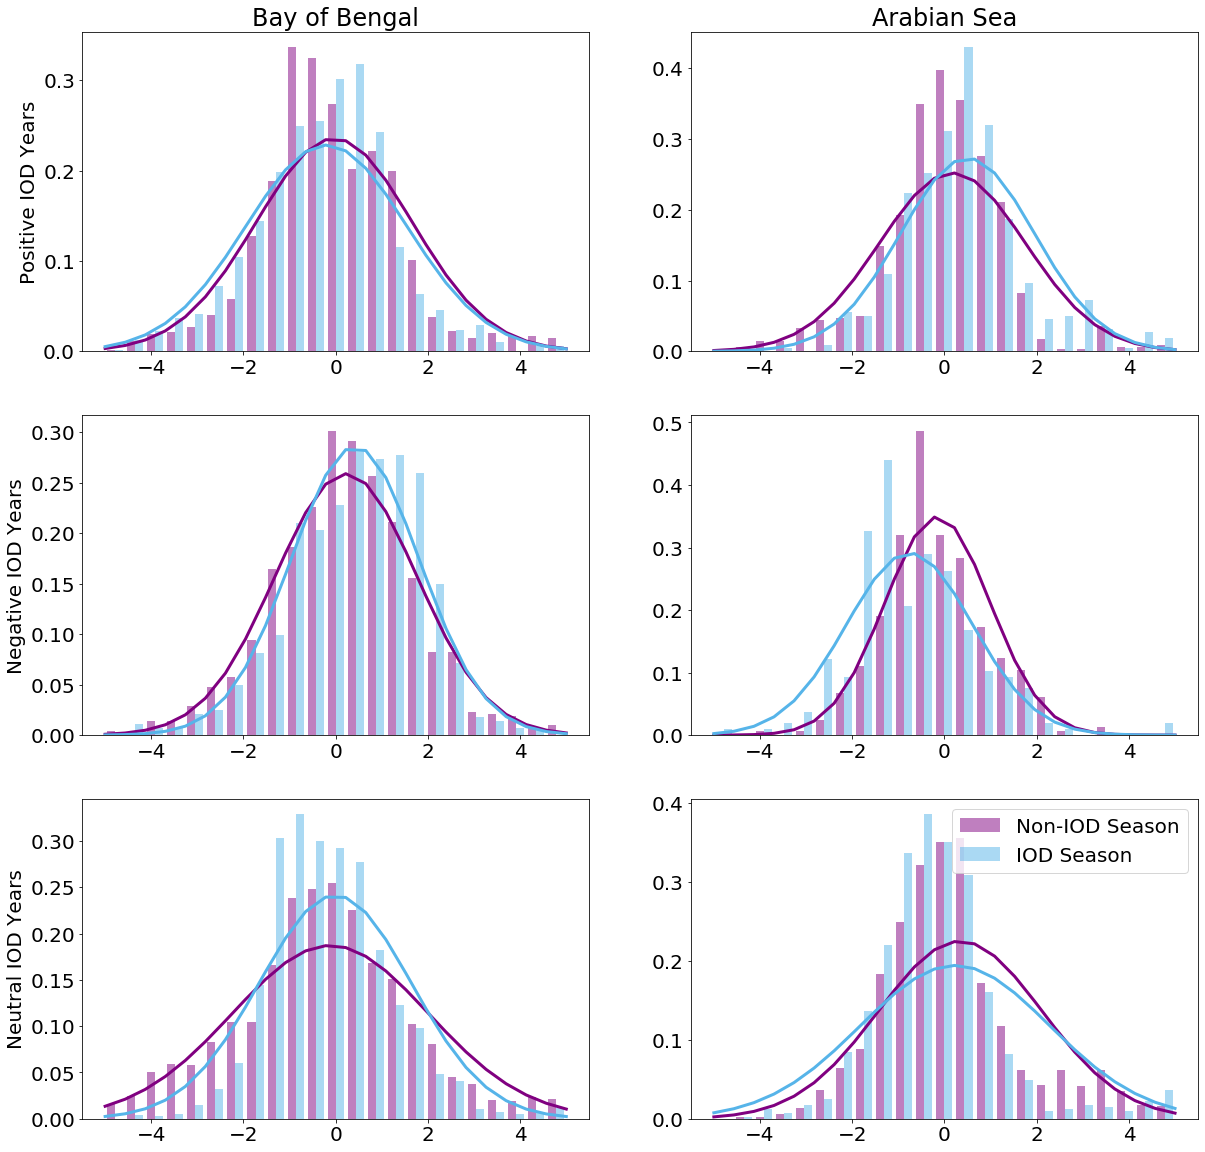

In [48]:
# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#
cnt = 1
phase_title = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
seas_title = ['Bay of Bengal','Arabian Sea']
fig = plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(-5,5,24)
for pp in range(3):

    for loc in range(2):
        # Make a separate list for each airline
        x1 = list(temp_anom_IODData[loc,0,pp])
        x2 = list(temp_anom_IODData[loc,1,pp])

        # Assign colors for each airline and the names
        colors = ['purple', '#56B4E9']
        names = ['Non-IOD Season','IOD Season']

        # Make the histogram using a list of lists
        # Normalize the flights and assign colors and names
        ax = fig.add_subplot(3,2,cnt)
        n, bins, patches = plt.hist([x1, x2],bins = binedges,
                 density = True,alpha = 0.5,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '-',c = colors[ii],linewidth = 3)

        # Plot formatting
        if (cnt == 5) | (cnt ==6):
            if var_type == 'TCD_200':
                plt.xlabel('Mean TCD-200dbar Temperature Anomaly')
            elif var_type == '10_200':
                plt.xlabel('Mean 10-200dbar Temperature Anomaly')
            elif var_type == '10_50':
                plt.xlabel('Mean 10-50dbar Temperature Anomaly')
            elif var_type == 'total':
                plt.xlabel('Mean Water Column Temperature Anomaly')
        if (cnt == 1) | (cnt ==3)| (cnt ==5):
            plt.ylabel(phase_title[pp])
#         plt.ylim(0,0.02)
#         plt.xlim(0,200)
        if (cnt == 1) | (cnt ==2):
            plt.title(seas_title[loc])
        if cnt == 6:
            plt.legend()
        cnt = cnt + 1

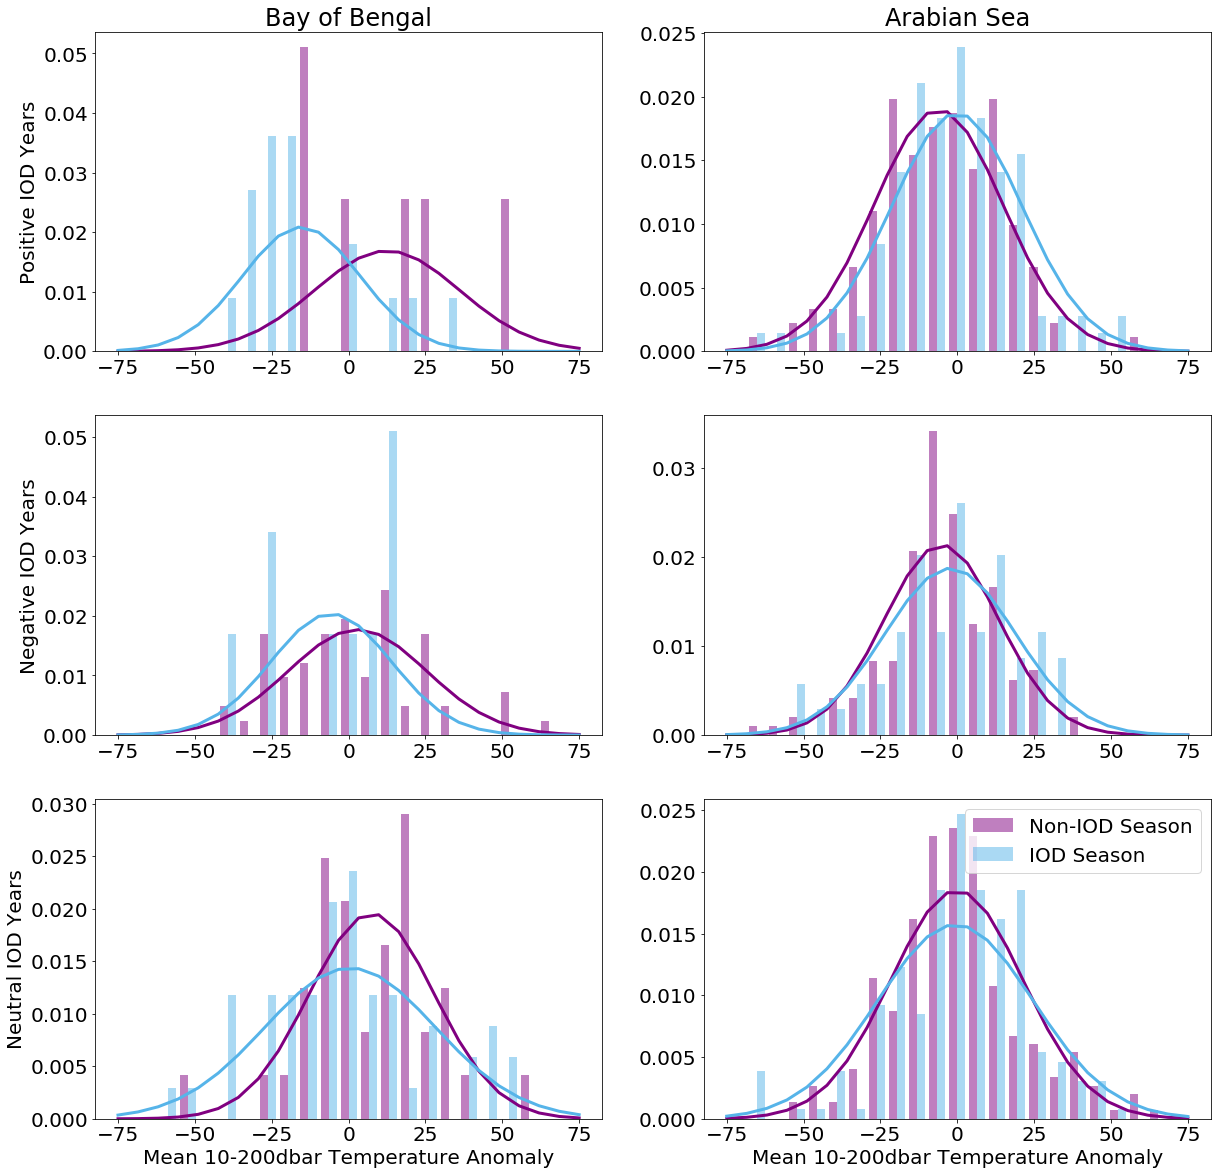

In [104]:
# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#
cnt = 1
phase_title = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
seas_title = ['Bay of Bengal','Arabian Sea']
fig = plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(-75,75,24)
for pp in range(3):

    for loc in range(2):
        # Make a separate list for each airline
        x1 = list(doxy_anom_IODData[loc,0,pp])
        x2 = list(doxy_anom_IODData[loc,1,pp])

        # Assign colors for each airline and the names
        colors = ['purple', '#56B4E9']
        names = ['Non-IOD Season','IOD Season']

        # Make the histogram using a list of lists
        # Normalize the flights and assign colors and names
        ax = fig.add_subplot(3,2,cnt)
        n, bins, patches = plt.hist([x1, x2],bins = binedges,
                 density = True,alpha = 0.5,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '-',c = colors[ii],linewidth = 3)

        # Plot formatting
        if (cnt == 5) | (cnt ==6):
            if var_type == 'TCD_200':
                plt.xlabel('Mean TCD-200dbar Temperature Anomaly')
            elif var_type == '10_200':
                plt.xlabel('Mean 10-200dbar Temperature Anomaly')
            elif var_type == '10_50':
                plt.xlabel('Mean 10-50dbar Temperature Anomaly')
            elif var_type == 'total':
                plt.xlabel('Mean Water Column Temperature Anomaly')
        if (cnt == 1) | (cnt ==3)| (cnt ==5):
            plt.ylabel(phase_title[pp])
#         plt.ylim(0,0.02)
#         plt.xlim(0,200)
        if (cnt == 1) | (cnt ==2):
            plt.title(seas_title[loc])
        if cnt == 6:
            plt.legend()
        cnt = cnt + 1

## SON Anomaly

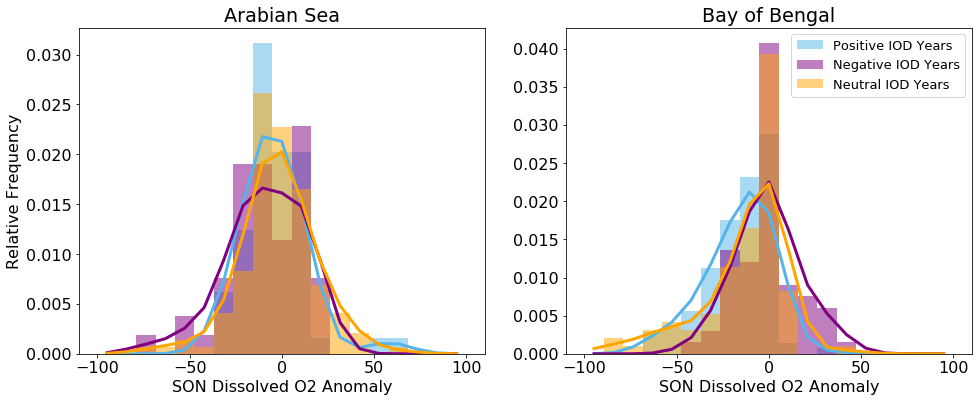

In [88]:
cnt = 1
seas_title = ['Arabian Sea','Bay of Bengal']
fig = plt.figure(figsize=(16, 6))
plt.rcParams.update({'font.size': 16})
binedges = np.linspace(-100,100,20)
var = doxy_anom_IODData
for bb in range(2):
    # take values for iod season
    x1 = list(var[bb,1,0])
    x2 = list(var[bb,1,1])
    x3 = list(var[bb,1,2])

    # Assign colors for each airline and the names
    colors = ['#56B4E9','purple','orange']
    names = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']

    # Make the histogram using a list of lists
    ax = fig.add_subplot(1,2,bb+1)
    for ii,x in enumerate([x1,x2,x3]):
        n, bins, patches = plt.hist(x,bins = binedges,
             density = True,
             alpha = 0.5,
             color = colors[ii], label=names[ii])
        bins=(np.array(bins)[:-1]+np.array(bins)[1:])/2
        plt.plot(bins, gaussian_filter(n,1), '-',c = colors[ii],linewidth = 3)


    # Plot formatting
    plt.xlabel('SON Dissolved O2 Anomaly')
    if bb == 0:
        plt.ylabel('Relative Frequency')
    plt.title(seas_title[bb])
    if bb == 1:
        plt.legend(prop={"size":13})
    cnt = cnt + 1

## Total Seasonal

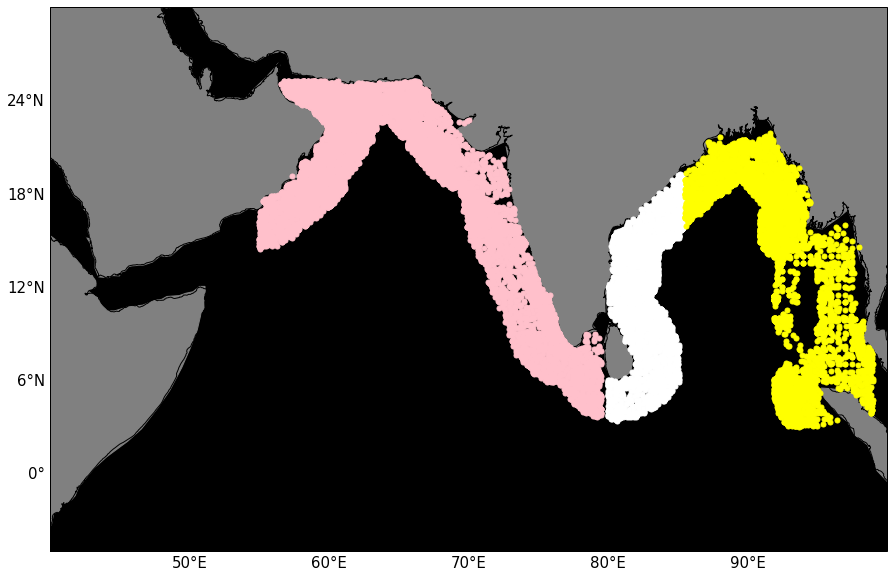

In [69]:
# Arabian Sea
ASind = (ds_CD.lat_coast > 3) & (ds_CD.lat_coast <25.25) & (ds_CD.lon_coast < 79.5) & (ds_CD.lon_coast >55)
temp_AS = ds_CD.temp_bot_ave_coast[ASind]
doxy_AS = ds_CD.doxy_bot_ave_coast[ASind]
doxy_WOA_AS = ds_CD.doxy_WOA_bot_ave_coast[ASind]
temp_anom_AS = ds_CD.temp_anom_bot_ave_coast[ASind]
doxy_anom_AS = ds_CD.doxy_anom_bot_ave_coast[ASind]
lat_AS = ds_CD.lat_coast[ASind]
lon_AS = ds_CD.lon_coast[ASind]
IODseas_AS = ds_CD.IODseason_coast[ASind]
time_AS = ds_CD.coast_time[ASind]
seas_AS = time_AS.dt.season


BoBind = (ds_CD.lat_coast > 3) & (ds_CD.lat_coast <26) & (ds_CD.lon_coast < 99) & (ds_CD.lon_coast >= 85.5)
temp_eBoB = ds_CD.temp_bot_ave_coast[BoBind]
doxy_eBoB = ds_CD.doxy_bot_ave_coast[BoBind]
doxy_WOA_eBoB = ds_CD.doxy_WOA_bot_ave_coast[BoBind]
temp_anom_eBoB = ds_CD.temp_anom_bot_ave_coast[BoBind]
doxy_anom_eBoB = ds_CD.doxy_anom_bot_ave_coast[BoBind]
lat_eBoB = ds_CD.lat_coast[BoBind]
lon_eBoB = ds_CD.lon_coast[BoBind]
IODseas_eBoB = ds_CD.IODseason_coast[BoBind]
time_eBoB = ds_CD.coast_time[BoBind]
seas_eBoB = time_eBoB.dt.season

BoBind = (ds_CD.lat_coast > 3) & (ds_CD.lat_coast <26) & (ds_CD.lon_coast < 85.5) & (ds_CD.lon_coast > 80)
temp_wBoB = ds_CD.temp_bot_ave_coast[BoBind]
doxy_wBoB = ds_CD.doxy_bot_ave_coast[BoBind]
doxy_WOA_wBoB = ds_CD.doxy_WOA_bot_ave_coast[BoBind]
temp_anom_wBoB = ds_CD.temp_anom_bot_ave_coast[BoBind]
doxy_anom_wBoB = ds_CD.doxy_anom_bot_ave_coast[BoBind]
lat_wBoB = ds_CD.lat_coast[BoBind]
lon_wBoB = ds_CD.lon_coast[BoBind]
IODseas_wBoB = ds_CD.IODseason_coast[BoBind]
time_wBoB = ds_CD.coast_time[BoBind]
seas_wBoB = time_wBoB.dt.season


def add_land(ax,bounds):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='10m',zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

bounds = [40,100,-5,30]
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
p =plt.scatter(lon_AS,lat_AS,
            s = 100,c='pink',marker = '.')

p =plt.scatter(lon_wBoB,lat_wBoB,
            s = 100,c='white',marker = '.')

p =plt.scatter(lon_eBoB,lat_eBoB,
            s = 100,c='yellow',marker = '.')

In [71]:
begin = '-05-01'
end = '-04-30'

doxy_IODData_seas = np.zeros([3,4,3], dtype=np.ndarray)
temp_IODData_seas = np.zeros([3,4,3], dtype=np.ndarray)
doxy_WOA_IODData_seas = np.zeros([3,4,3], dtype=np.ndarray)
doxy_anom_IODData_seas = np.zeros([3,4,3], dtype=np.ndarray)
temp_anom_IODData_seas = np.zeros([3,4,3], dtype=np.ndarray)
lat_IODData_seas = np.zeros([3,4,3], dtype=np.ndarray)
lon_IODData_seas = np.zeros([3,4,3], dtype=np.ndarray)
time_IODData_seas = np.zeros([3,4,3], dtype=np.ndarray)

for bb in range(3):
    if bb == 0:
        temp = temp_AS
        doxy = doxy_AS
        doxy_WOA = doxy_WOA_AS
        temp_anom = temp_anom_AS
        doxy_anom = doxy_anom_AS
        lat = lat_AS
        lon = lon_AS
        IODseason = IODseas_AS
        season = seas_AS
        t = time_AS
    elif bb == 1:
        temp = temp_wBoB
        doxy = doxy_wBoB
        doxy_WOA = doxy_WOA_wBoB
        temp_anom = temp_anom_wBoB
        doxy_anom = doxy_anom_wBoB
        lat = lat_wBoB
        lon = lon_wBoB
        IODseason = IODseas_wBoB
        season = seas_wBoB
        t = time_wBoB
    elif bb == 2:
        temp = temp_eBoB
        doxy = doxy_eBoB
        doxy_WOA = doxy_WOA_eBoB
        temp_anom = temp_anom_eBoB
        doxy_anom = doxy_anom_eBoB
        lat = lat_eBoB
        lon = lon_eBoB
        IODseason = IODseas_eBoB
        season = seas_eBoB
        t = time_eBoB

    IODyears = [posIODyears,negIODyears,neuIODyears]
    
    for pp,phase in enumerate(IODyears):
        
        doxy_data = []
        doxy_WOA_data = []
        temp_data = []
        doxy_anom_data = []
        temp_anom_data = []
        lat_data = []
        lon_data = []
        time_data = []
        IODseason_data = []
        season_data = []

        for ii,year in enumerate(phase):
            start_time = str(year) + begin
            end_time = str(year+1) + end
            time_slice = slice(start_time, end_time)
            doxy_data.extend(np.array(doxy.sel(coast_time=time_slice)))
            doxy_WOA_data.extend(np.array(doxy_WOA.sel(coast_time=time_slice)))
            temp_data.extend(np.array(temp.sel(coast_time=time_slice)))
            doxy_anom_data.extend(np.array(doxy_anom.sel(coast_time=time_slice)))
            temp_anom_data.extend(np.array(temp_anom.sel(coast_time=time_slice)))
            lat_data.extend(np.array(lat.sel(coast_time=time_slice)))
            lon_data.extend(np.array(lon.sel(coast_time=time_slice)))
            time_data.extend(np.array(t.sel(coast_time=time_slice)))
            IODseason_data.extend(np.array(IODseason.sel(coast_time=time_slice)))
            season_data.extend(np.array(season.sel(coast_time=time_slice)))
            
        # next group by seasons
        # create a pandas dataframe
        df = pd.DataFrame(dict(
                doxy = np.array(doxy_data),
                doxy_WOA = np.array(doxy_WOA_data),
                temp = np.array(temp_data),
                doxy_anom = np.array(doxy_anom_data),
                temp_anom = np.array(temp_anom_data),
                lat= np.array(lat_data),
                lon= np.array(lon_data),
                time = np.array(time_data),
                IODseason = np.array(IODseason_data),
                season = np.array(season_data)
            ))
            
        seas_grouped = df.groupby(['season'])
        
        for ss,seas_group in seas_grouped:
            if ss == 'DJF':
                ssn = 0
            elif ss == 'JJA':
                ssn = 1
            elif ss == 'MAM':
                ssn = 2
            else:
                ssn = 3
            doxy_IODData_seas[bb,ssn,pp] = np.array(seas_group.doxy)
            doxy_WOA_IODData_seas[bb,ssn,pp] = np.array(seas_group.doxy_WOA)
            temp_IODData_seas[bb,ssn,pp] = np.array(seas_group.temp)
            doxy_anom_IODData_seas[bb,ssn,pp] = np.array(seas_group.doxy_anom)
            temp_anom_IODData_seas[bb,ssn,pp] = np.array(seas_group.temp_anom)
            lat_IODData_seas[bb,ssn,pp] = np.array(seas_group.lat)
            lon_IODData_seas[bb,ssn,pp] = np.array(seas_group.lon)
            time_IODData_seas[bb,ssn,pp] = np.array(seas_group.time)

/home/jennap/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6743: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/jennap/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6744: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/home/jennap/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


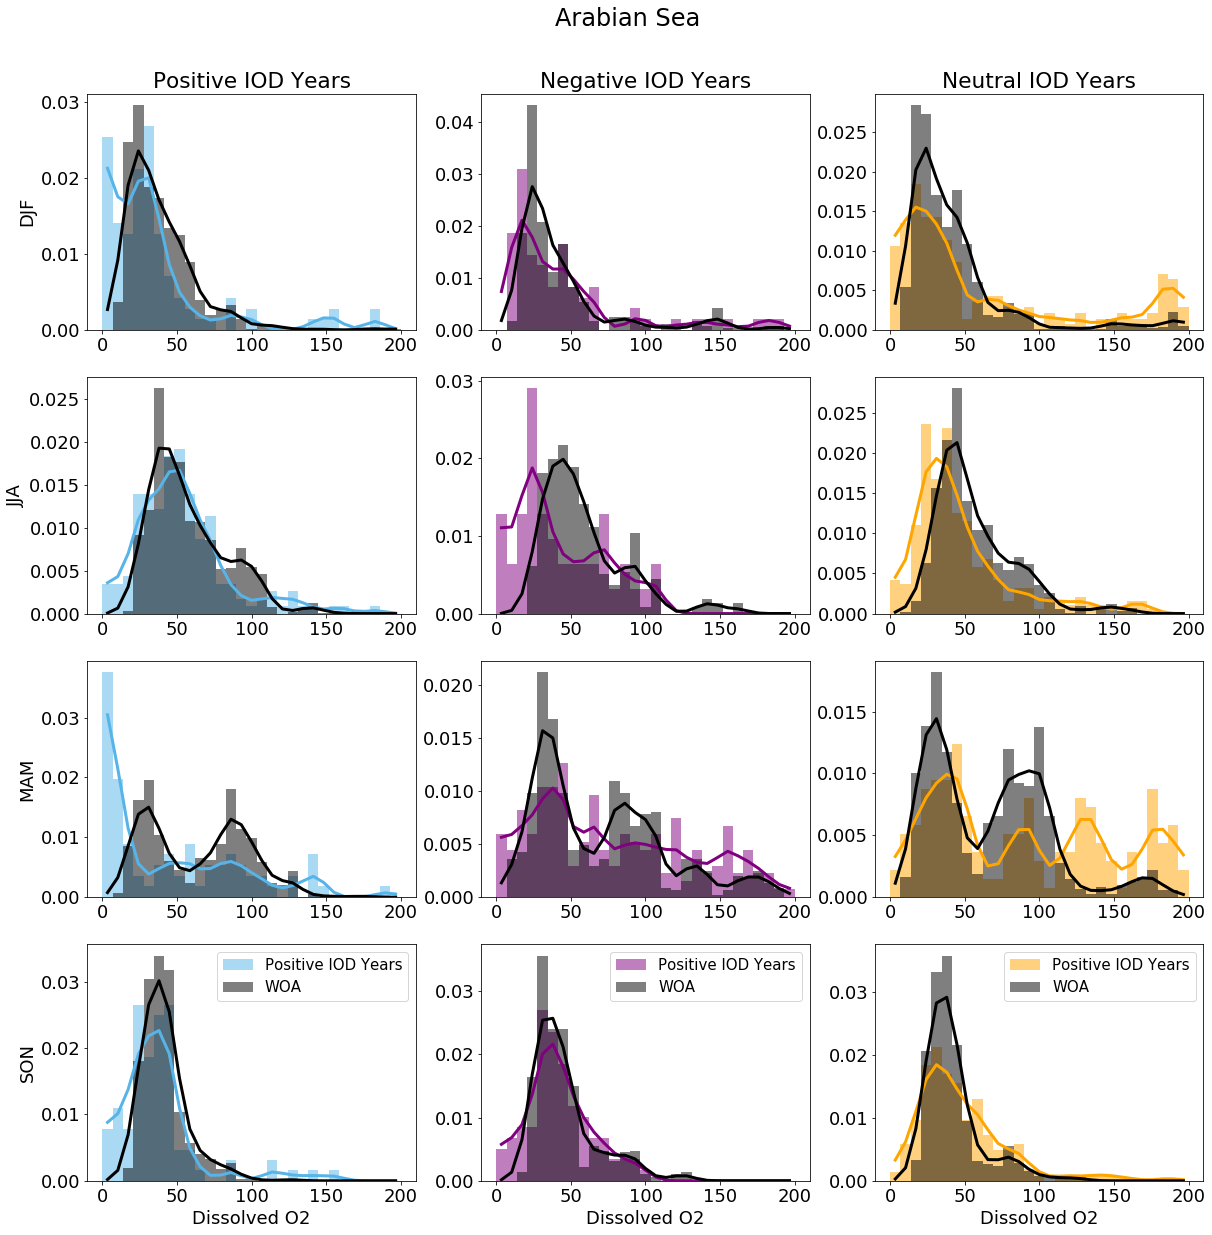

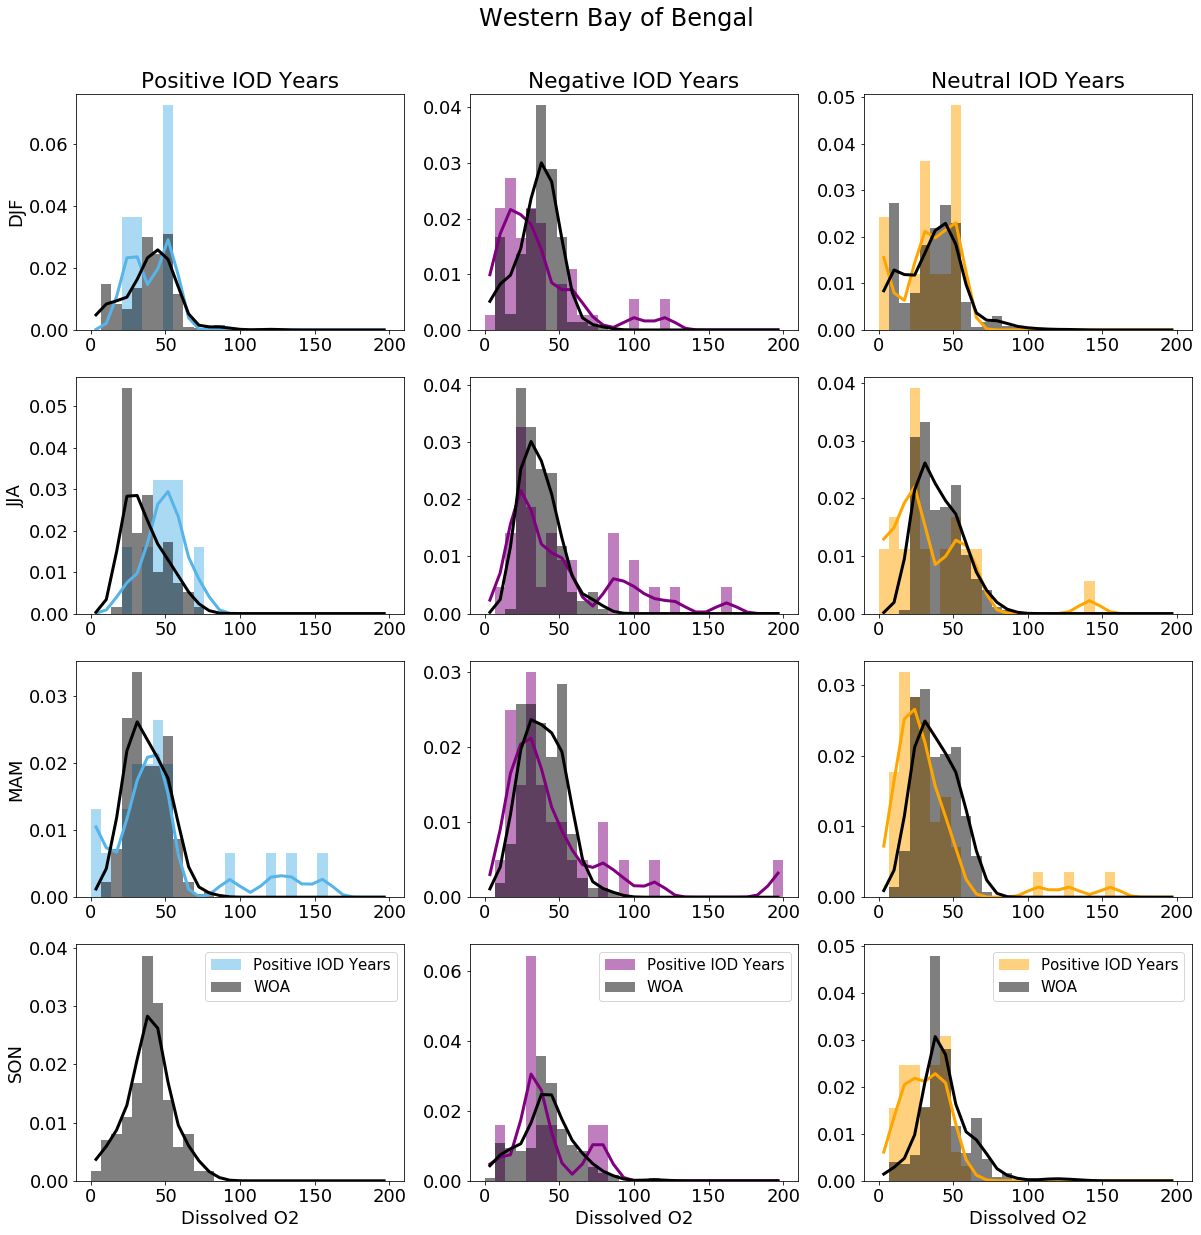

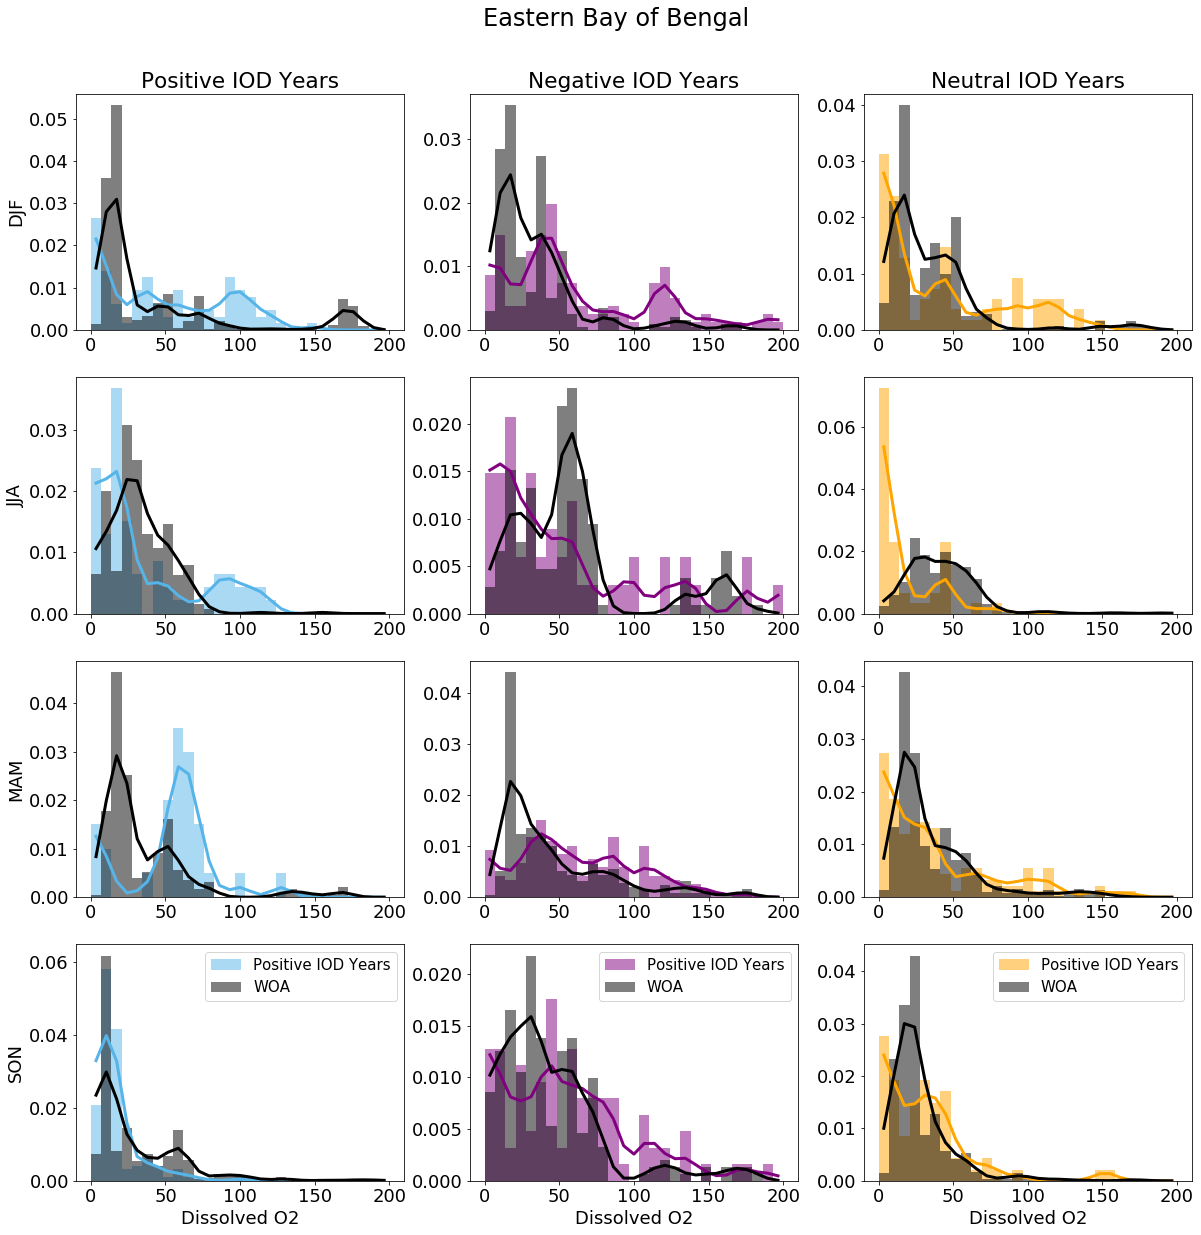

In [84]:

seas_title = ['Arabian Sea','Western Bay of Bengal','Eastern Bay of Bengal']
ylabels = ['DJF','JJA','MAM','SON']
names = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
colors = ['#56B4E9','purple','orange']
binedges = np.linspace(0,200,30)

for bb in range(3):
    cnt = 1
    fig = plt.figure(figsize=(20, 20))
    plt.rcParams.update({'font.size': 18})
    
    for ss in range(4):
        for pp in range(3):

            x1 = list(doxy_IODData_seas[bb,ss,pp])
            x2 = list(doxy_WOA_IODData_seas[bb,ss,pp])


            # Make the histogram using a list of lists
            ax = fig.add_subplot(4,3,cnt)
            for ii,x in enumerate([x1,x2]):
                clr = [colors[pp],'k']
                lbls = [names[ii],'WOA']
                n, bins, patches = plt.hist(x,bins = binedges,
                     density = True,
                     alpha = 0.5,
                     color = clr[ii], label=lbls[ii])
                bins=(np.array(bins)[:-1]+np.array(bins)[1:])/2
                plt.plot(bins, gaussian_filter(n,1), '-',c = clr[ii],linewidth = 3)


            # Plot formatting
            if (cnt == 10) | (cnt == 11) | (cnt == 12):
                plt.xlabel('Dissolved O2')
            if (cnt == 1) | (cnt == 4) | (cnt == 7)| (cnt == 10):
                plt.ylabel(ylabels[ss])
            if (cnt == 1) | (cnt == 2) | (cnt == 3):
                plt.title(names[pp])
            if (cnt == 10) | (cnt == 11) | (cnt == 12):
                plt.legend(prop={"size":15})
            plt.suptitle(seas_title[bb], y=.94, fontsize = 24)
            cnt = cnt + 1

/home/jennap/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6743: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/jennap/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6744: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/home/jennap/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


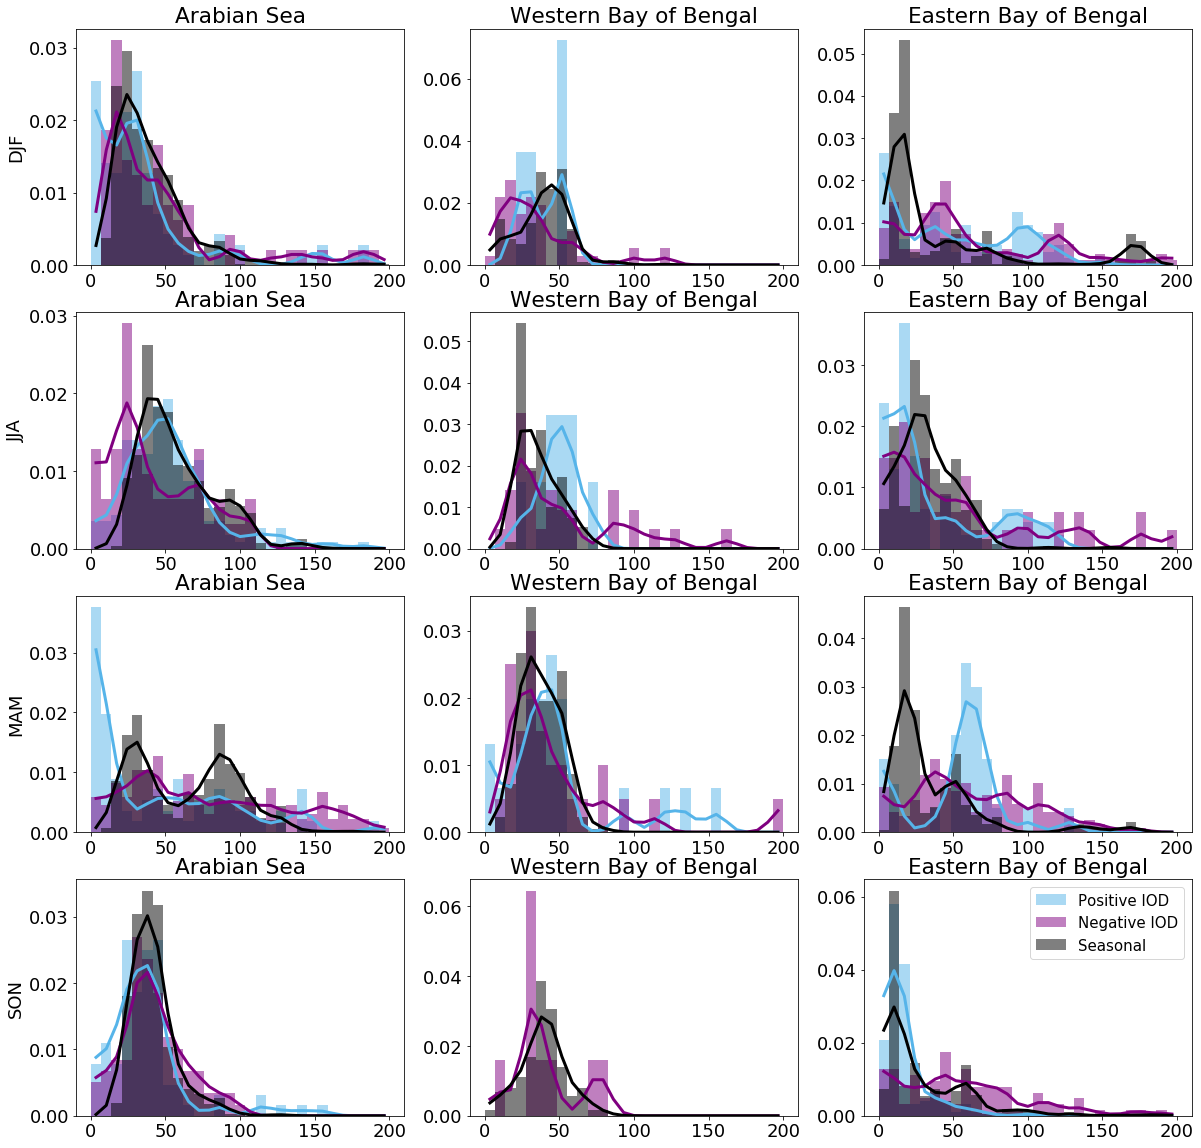

In [75]:
cnt = 1
seas_title = ['Arabian Sea','Western Bay of Bengal','Eastern Bay of Bengal']
ylabels = ['DJF','JJA','MAM','SON']
fig = plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 18})
binedges = np.linspace(0,200,30)
var = doxy_IODData_seas
for ss in range(4):
    for bb in range(3):
        # take values for iod season
        x1 = list(var[bb,ss,0])
        x2 = list(var[bb,ss,1])
        x3 = list(doxy_WOA_IODData_seas[bb,ss,0])

        # Assign colors for each airline and the names
        colors = ['#56B4E9','purple','black']
        names = ['Positive IOD','Negative IOD','Seasonal']

        # Make the histogram using a list of lists
        ax = fig.add_subplot(4,3,cnt)
        for ii,x in enumerate([x1,x2,x3]):
            n, bins, patches = plt.hist(x,bins = binedges,
                 density = True,
                 alpha = 0.5,
                 color = colors[ii], label=names[ii])
            bins=(np.array(bins)[:-1]+np.array(bins)[1:])/2
            plt.plot(bins, gaussian_filter(n,1), '-',c = colors[ii],linewidth = 3)


        # Plot formatting
        if (cnt == 13) | (cnt == 14) | (cnt == 15):
            plt.xlabel('Dissolved O2')
        if (cnt == 1) | (cnt == 4) | (cnt == 7)| (cnt == 10):
            plt.ylabel(ylabels[ss])
        plt.title(seas_title[bb])
        if cnt == 12:
            plt.legend(prop={"size":15})
        cnt = cnt + 1

## Total

In [ ]:
cnt = 1
phase_title = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
seas_title = ['AS','BoB']
fig = plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(0,50,24)
for pp in range(3):
    for bb in range(2):
        # Make a separate list for each airline
        x1 = list(temp_IODData[bb,1,pp])
        x2 = list(temp_IODData[bb,0,pp])
        # I switch these so that the IOD season is the first one intentionally for plotting

        # Assign colors for each airline and the names
        colors = ['#56B4E9','purple']
        names = ['IOD Season','Off Season']

        # Make the histogram using a list of lists
        # Normalize the flights and assign colors and names
        ax = fig.add_subplot(3,2,cnt)
        n, bins, patches = plt.hist([x1, x2],bins = binedges,
                 density = True,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '--',c = colors[ii],linewidth = 3)

        # Plot formatting
        if (cnt == 5) | (cnt ==6):
            plt.xlabel('Mean Bottom Temperature')
        if (cnt == 1) | (cnt ==3)| (cnt ==5):
            plt.ylabel(phase_title[pp])
#         plt.ylim(0,0.02)
#         plt.xlim(0,200)
        if (cnt == 1) | (cnt ==2):
            plt.title(seas_title[bb])
        if cnt == 6:
            plt.legend()
        cnt = cnt + 1

In [ ]:
cnt = 1
phase_title = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
seas_title = ['AS','BoB']
fig = plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(0,200,24)
for pp in range(3):
    for bb in range(2):
        # Make a separate list for each airline
        x1 = list(doxy_IODData[bb,1,pp])
        x2 = list(doxy_IODData[bb,0,pp])
        # I switch these so that the IOD season is the first one intentionally for plotting

        # Assign colors for each airline and the names
        colors = ['#56B4E9','purple']
        names = ['IOD Season','Off Season']

        # Make the histogram using a list of lists
        # Normalize the flights and assign colors and names
        ax = fig.add_subplot(3,2,cnt)
        n, bins, patches = plt.hist([x1, x2],bins = binedges,
                 density = True,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '--',c = colors[ii],linewidth = 3)

        # Plot formatting
        if (cnt == 5) | (cnt ==6):
            plt.xlabel('Mean Bottom Dissolved O2')
        if (cnt == 1) | (cnt ==3)| (cnt ==5):
            plt.ylabel(phase_title[pp])
#         plt.ylim(0,0.02)
#         plt.xlim(0,200)
        if (cnt == 1) | (cnt ==2):
            plt.title(seas_title[bb])
        if cnt == 6:
            plt.legend()
        cnt = cnt + 1

In [ ]:
cnt = 1
seas_title = ['AS','BoB']
xlabels = ['Mean Bottom Temperature','Mean Bottom Dissolved O2']
fig = plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 20})
binedges = list([np.linspace(0,50,24),np.linspace(0,200,24)])
for vv,var in enumerate(list([temp_IODData,doxy_IODData])):
    for bb in range(2):
        # take values for iod season
        x1 = list(var[bb,1,0])
        x2 = list(var[bb,1,1])
        x3 = list(var[bb,1,2])

        # Assign colors for each airline and the names
        colors = ['#56B4E9','purple','green']
        names = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']

        # Make the histogram using a list of lists
        ax = fig.add_subplot(2,2,cnt)
        n, bins, patches = plt.hist([x1, x2, x3],bins = binedges[vv],
                 density = True,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2, x3]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '--',c = colors[ii],linewidth = 3)

        # Plot formatting
        plt.xlabel(xlabels[vv])
        if (cnt == 1)| (cnt == 3):
            plt.ylabel('PDF')
        if (cnt == 1)| (cnt == 2):
            plt.title(seas_title[bb])
        if cnt == 4:
            plt.legend()
        cnt = cnt + 1

## Anomaly

In [ ]:
cnt = 1
phase_title = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
seas_title = ['AS','BoB']
fig = plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(-5,5,24)
for pp in range(3):
    for bb in range(2):
        # Make a separate list for each airline
        x1 = list(temp_anom_IODData[bb,1,pp])
        x2 = list(temp_anom_IODData[bb,0,pp])
        # I switch these so that the IOD season is the first one intentionally for plotting

        # Assign colors for each airline and the names
        colors = ['#56B4E9','purple']
        names = ['IOD Season','Off Season']

        # Make the histogram using a list of lists
        # Normalize the flights and assign colors and names
        ax = fig.add_subplot(3,2,cnt)
        n, bins, patches = plt.hist([x1, x2],bins = binedges,
                 density = True,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '--',c = colors[ii],linewidth = 3)

        # Plot formatting
        if (cnt == 5) | (cnt ==6):
            plt.xlabel('Mean Bottom Temperature Anomaly')
        if (cnt == 1) | (cnt ==3)| (cnt ==5):
            plt.ylabel(phase_title[pp])
#         plt.ylim(0,0.02)
#         plt.xlim(0,200)
        if (cnt == 1) | (cnt ==2):
            plt.title(seas_title[bb])
        if cnt == 6:
            plt.legend()
        cnt = cnt + 1

In [ ]:
cnt = 1
phase_title = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
seas_title = ['AS','BoB']
fig = plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(-100,100,24)
for pp in range(3):
    for bb in range(2):
        # Make a separate list for each airline
        x1 = list(doxy_anom_IODData[bb,1,pp])
        x2 = list(doxy_anom_IODData[bb,0,pp])
        print(len(x1),len(x2))
        # I switch these so that the IOD season is the first one intentionally for plotting

        # Assign colors for each airline and the names
        colors = ['#56B4E9','purple']
        names = ['IOD Season','Off Season']

        # Make the histogram using a list of lists
        # Normalize the flights and assign colors and names
        ax = fig.add_subplot(3,2,cnt)
        n, bins, patches = plt.hist([x1, x2],bins = binedges,
                 density = True,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '--',c = colors[ii],linewidth = 3)

        # Plot formatting
        if (cnt == 5) | (cnt ==6):
            plt.xlabel('Mean Bottom Dissolved O2 Anomaly')
        if (cnt == 1) | (cnt ==3)| (cnt ==5):
            plt.ylabel(phase_title[pp])
#         plt.ylim(0,0.02)
#         plt.xlim(0,200)
        if (cnt == 1) | (cnt ==2):
            plt.title(seas_title[bb])
        if cnt == 6:
            plt.legend()
        cnt = cnt + 1